# 4. Spatial and spectral matching between imaging data and IFS data cube using `piXedfit_spectrophotometric` -- Part II

<font size="4">In this second part, we correct for the wavelength-dependant mismatch between the IFS spectra and the photometric SEDs on pixel scales. The mismatch can be caused by at least two factors: systematics in the data processing (PSF matching, spatial resampling, reprojection, etc.) of the broadband imaging and IFS data and the uncertainty in the flux calibration of the photometric and IFS data. The correction can be done using `piXedfit.piXedfit_spectrophotometric.match_specphoto` function. Basically, this function will perform simple SED fitting to the photometric SEDs (i.e., withouth IFS spectra) of individual pixels and find the best-fit model spectra. For a given pixel, the wavelength-dependent ratio between the best-fit model spectrum and the IFS spectrum is fitted with third-order Legendre polynomial function to get smooth correction factor (as function of wavelength). Then this correction factor is applied to the IFS spectrum.</font>

## 4.1. Generate model SED templates
<font size="4"> Before running `match_specphoto` function, we need to generate model SEDs. This set of models should be generated for each galaxy. The generated models would also be used for subsequent analyses, such as SED fitting. To generate model SEDs, we can use `piXedfit.piXedfit_model.save_models` function. An example of script is given: `gen_models.py`. This will produce 100000 models and uses 10 cores to compute. These numbers are flexible: users can flexibly change them. It is recommended to execute the script on a computer (server) with sufficient number of cores. The ouput is a FITS file. In this example, the output file is `ngc309_models.fits`.</font>

## 4.2. Run Images+IFS matching: Part II. Correcting wavelength-dependent mismatch

In [1]:
import numpy as np
from astropy.io import fits
import os, sys
import matplotlib.pyplot as plt

global PIXEDFIT_HOME
PIXEDFIT_HOME = os.environ['PIXEDFIT_HOME']
sys.path.insert(0, PIXEDFIT_HOME)

%matplotlib inline

In [2]:
from piXedfit.piXedfit_spectrophotometric import match_specphoto

<font size="4"> The following calculation is heavy and could take long time (hours) to finish, depending on the number of pixels (that have spec+photo SED) and the number of cores used (input argument: nproc) in the calculation. It's recommended to run this calculation on a multicores computer (server). The computational time can be shorten by inncreasing the number of cores. An example of script for executing this function separately (from the notebooks) is given: `script_corr_specphoto.py`. </font>   

In [3]:
specphoto_file = "specphoto_fluxmap_ngc309.fits"
name_saved_randmod = "ngc309_models.fits.gz"       # model SEDs generated before
name_out_fits = "corr_%s" % specphoto_file
match_specphoto(specphoto_file=specphoto_file, spec_sigma=2.6, 
                name_saved_randmod=name_saved_randmod, 
                nproc=10, name_out_fits=name_out_fits)

'corr_specphoto_fluxmap_ngc309.fits'

## 4.3. Check the result: spectrophotometric data cube

In [3]:
cube = fits.open("corr_specphoto_fluxmap_ngc309.fits")
cube.info()
header = cube[0].header
print (header)

Filename: corr_specphoto_fluxmap_ngc309.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1  PHOTO_REGION    1 ImageHDU         8   (131, 131)   float64   
  2  SPEC_REGION    1 ImageHDU         8   (131, 131)   float64   
  3  PHOTO_FLUX    1 ImageHDU         9   (131, 131, 12)   float64   
  4  PHOTO_FLUXERR    1 ImageHDU         9   (131, 131, 12)   float64   
  5  WAVE          1 ImageHDU         7   (1901,)   float64   
  6  SPEC_FLUX     1 ImageHDU         9   (131, 131, 1901)   float64   
  7  SPEC_FLUXERR    1 ImageHDU         9   (131, 131, 1901)   float64   
  8  MOD_WAVE      1 ImageHDU         7   (1553,)   float64   
  9  MOD_FLUX      1 ImageHDU         9   (131, 131, 1553)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions 

<font size="4"> Get the 3D data cubes </font>

In [4]:
photo_region = cube['PHOTO_REGION'].data
spec_region = cube['SPEC_REGION'].data
wave = cube['wave'].data
photo_flux = cube['PHOTO_FLUX'].data
photo_flux_err = cube['PHOTO_FLUXERR'].data
spec_flux = cube['SPEC_FLUX'].data
spec_flux_err = cube['SPEC_FLUXERR'].data
# get model: best-fit to photometric SED
mod_wave = cube['MOD_WAVE'].data
mod_flux = cube['MOD_FLUX'].data

# get unit
unit = header['unit']
cube.close()

<font size="4"> See coverages of Images and IFS

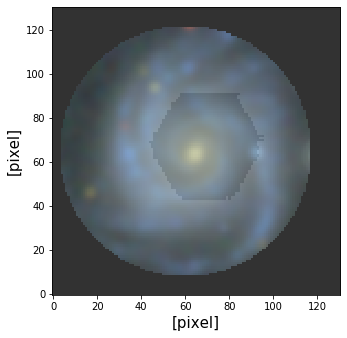

In [5]:
%matplotlib inline

from astropy.visualization import make_lupton_rgb

g = photo_flux[3]*10
r = photo_flux[4]*10
i = photo_flux[5]*10

rgb_default = make_lupton_rgb(i, r, g)

### plot photo and spec+photo regio
fig1 = plt.figure(figsize=(5,5))
f1 = plt.subplot()
plt.xlabel('[pixel]', fontsize=15)
plt.ylabel('[pixel]', fontsize=15)

plt.imshow(rgb_default, origin='lower', alpha=1.0)
plt.imshow(spec_region*5, origin='lower', cmap='Greys', alpha=0.2, vmin=0, vmax=10)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)

<font size="4"> **Check SEDs of some pixels** </font>

In [6]:
# get photometric and spectroscopic SEDs of pixels:
#transpose (band,y,x) => (y,x,band):
pix_photo_SED = np.transpose(photo_flux, axes=(1, 2, 0))*unit           ## erg/s/cm^2/A
pix_photo_SED_err = np.transpose(photo_flux_err, axes=(1, 2, 0))*unit

#transpose (wavelength,y,x) => (y,x,wavelength):
pix_spec_SED = np.transpose(spec_flux, axes=(1, 2, 0))*unit
pix_spec_SED_err = np.transpose(spec_flux_err, axes=(1, 2, 0))*unit
pix_mod_spec_SED = np.transpose(mod_flux, axes=(1, 2, 0))*unit

In [7]:
# get filters
nbands = header['nfilters']
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(header[str_temp])

# get central wavelength of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

<font size="4"> Plot SEDs of some pixels in the central region. The black spectra are the best-fit model to photometric SED that was used as reference in correcting for the photometry vs. spectroscopy mismatch. </font>

/home/abdurrouf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/abdurrouf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/abdurrouf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed a

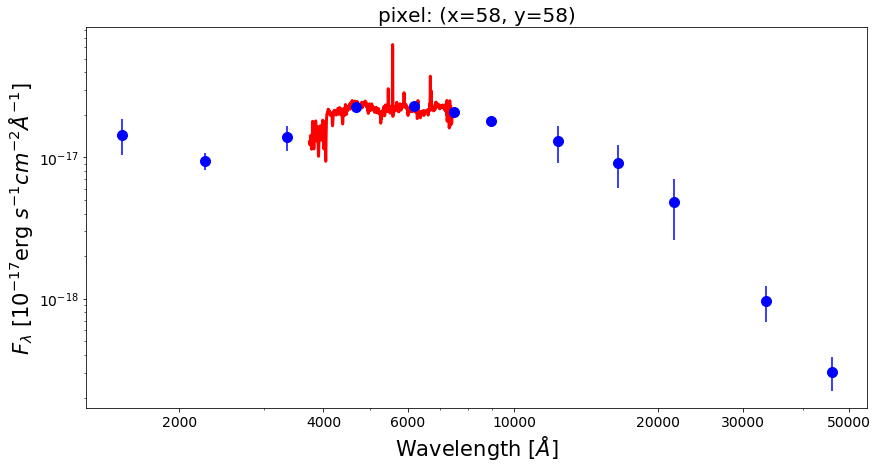

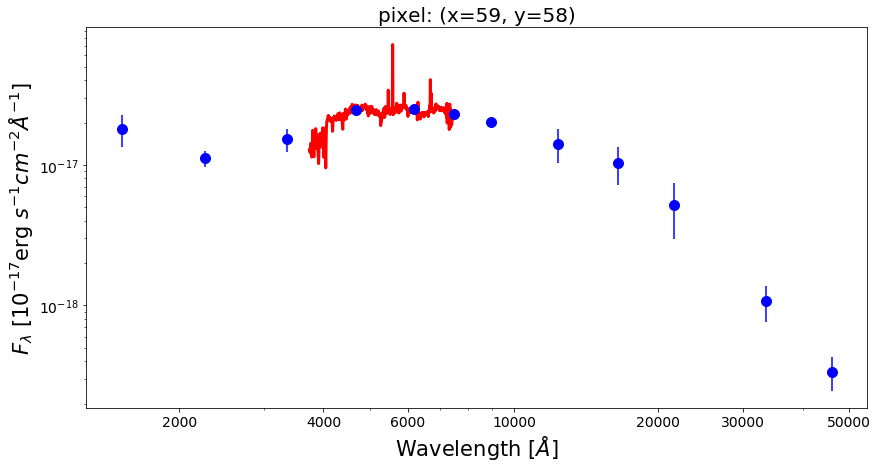

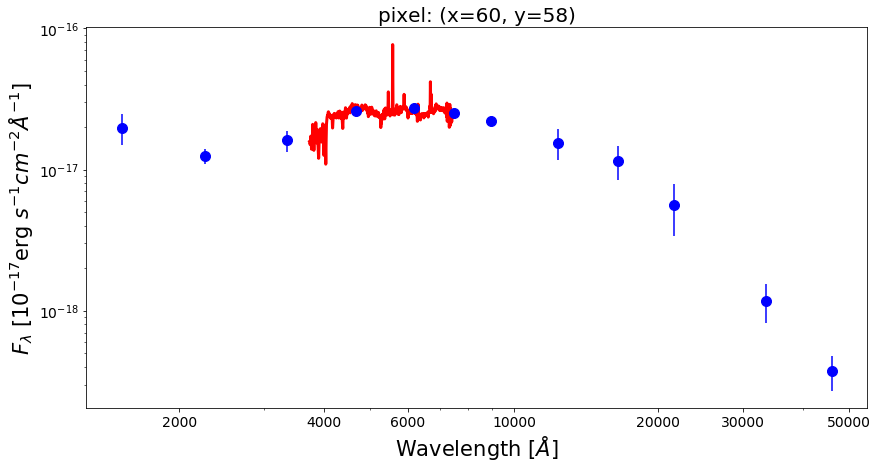

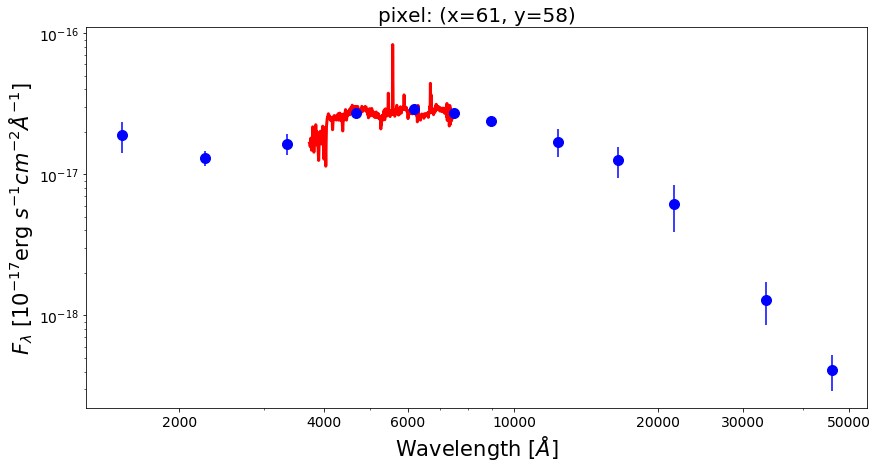

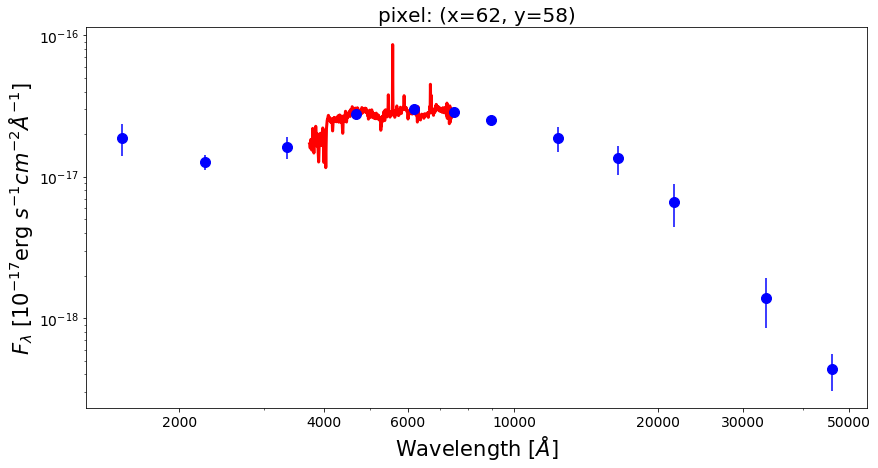

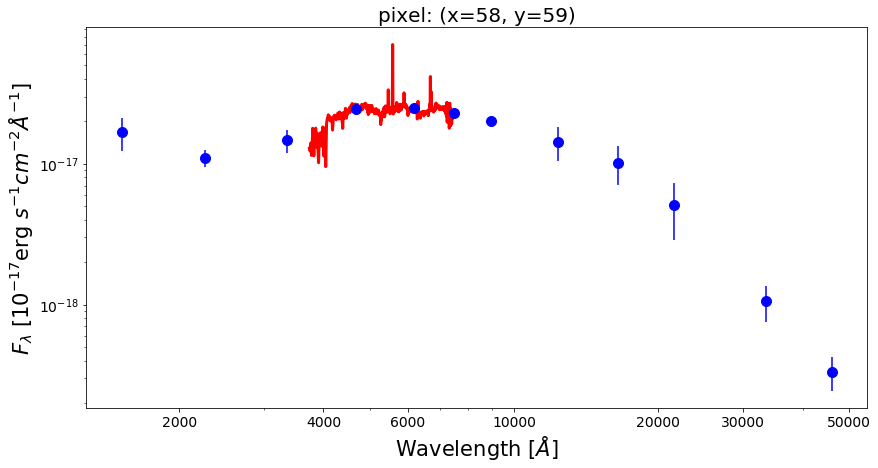

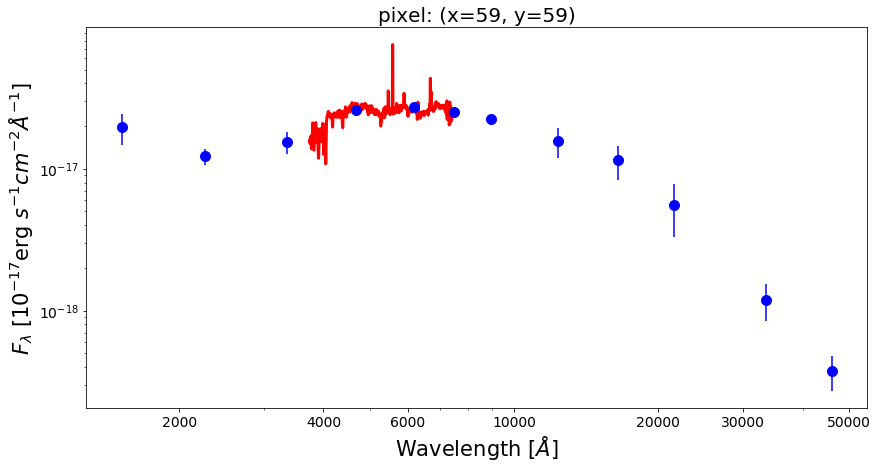

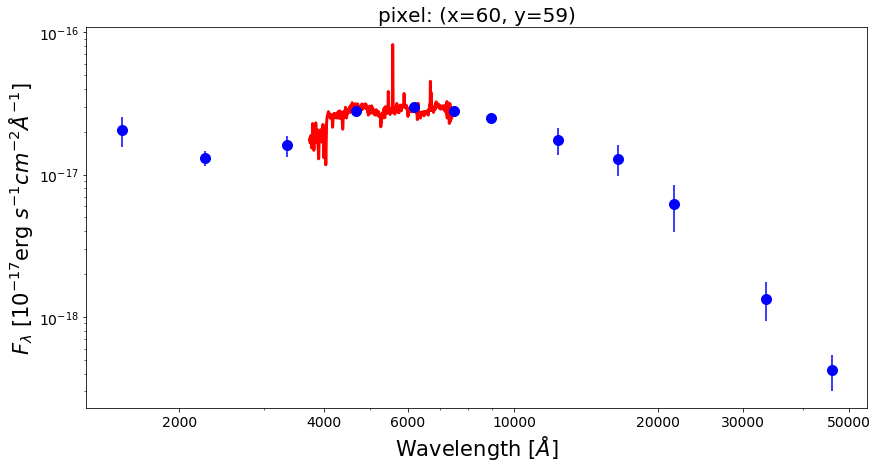

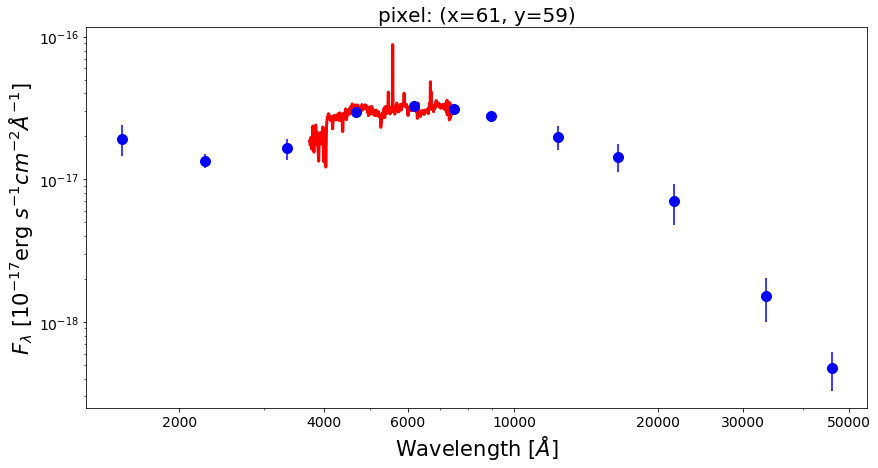

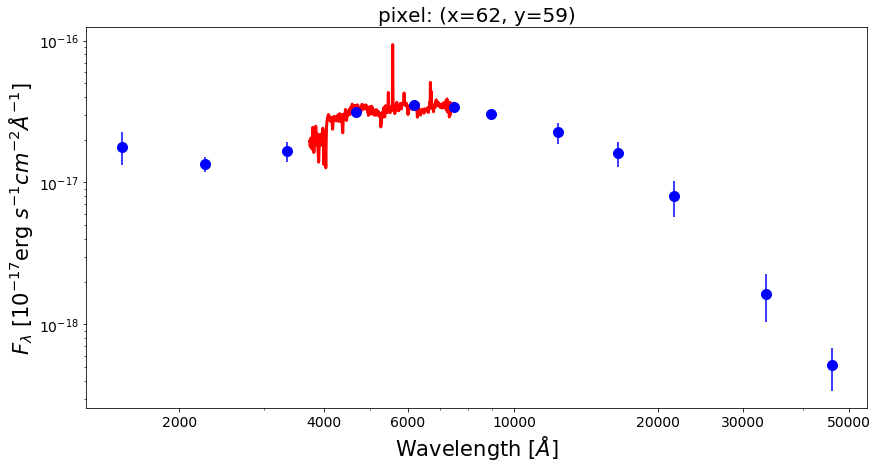

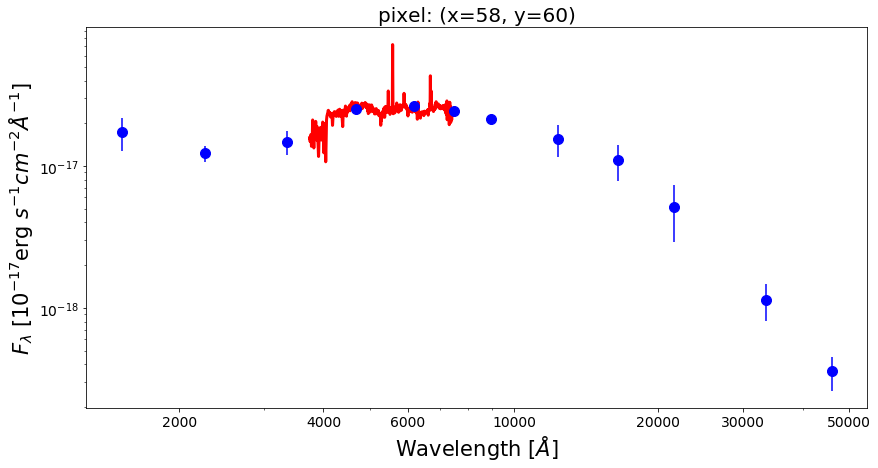

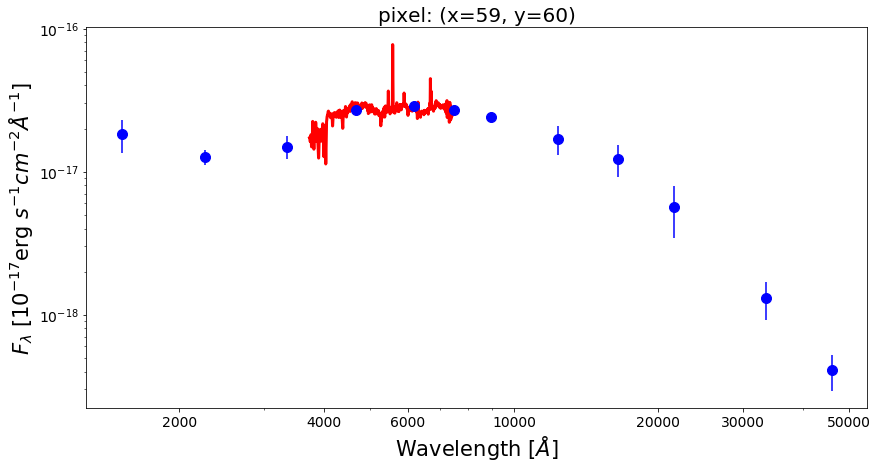

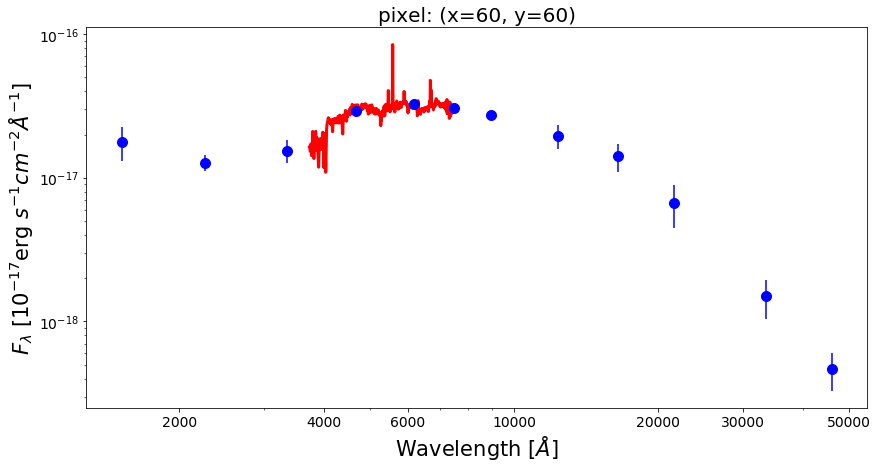

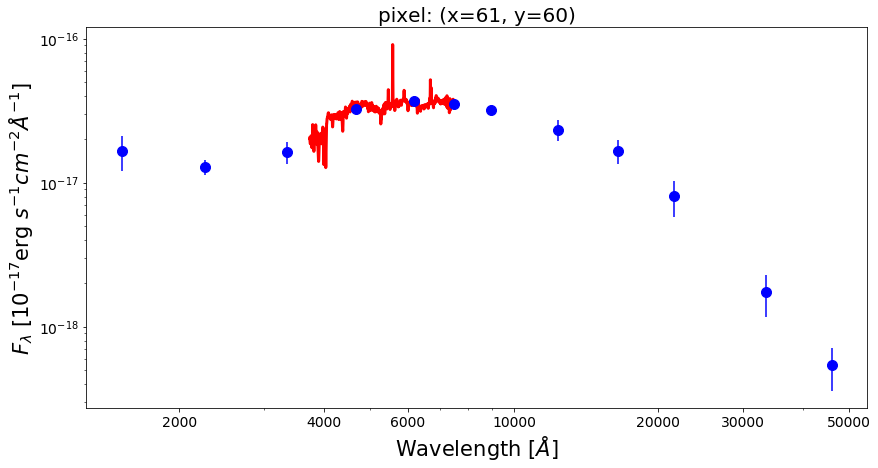

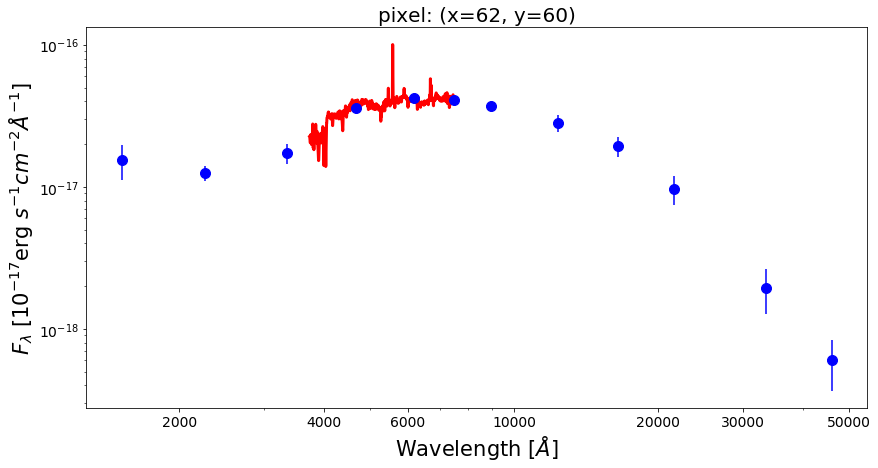

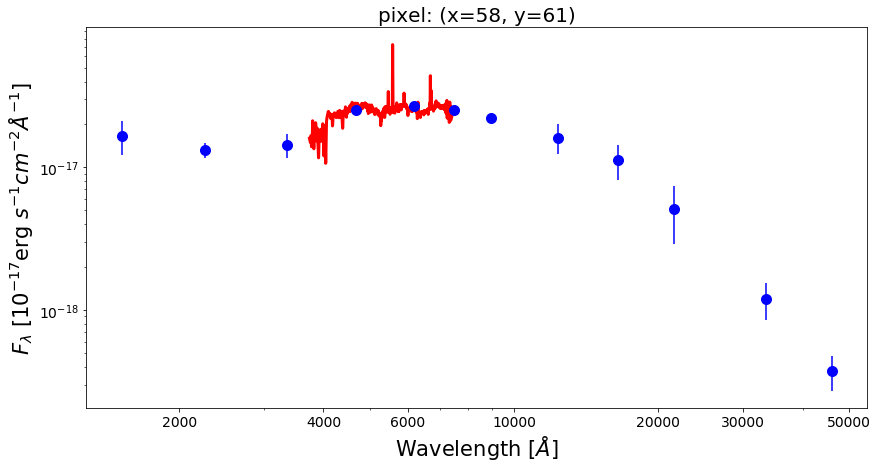

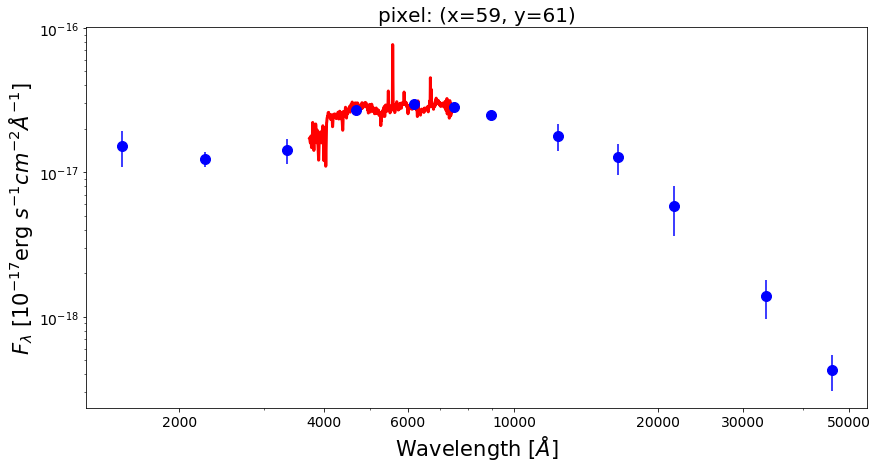

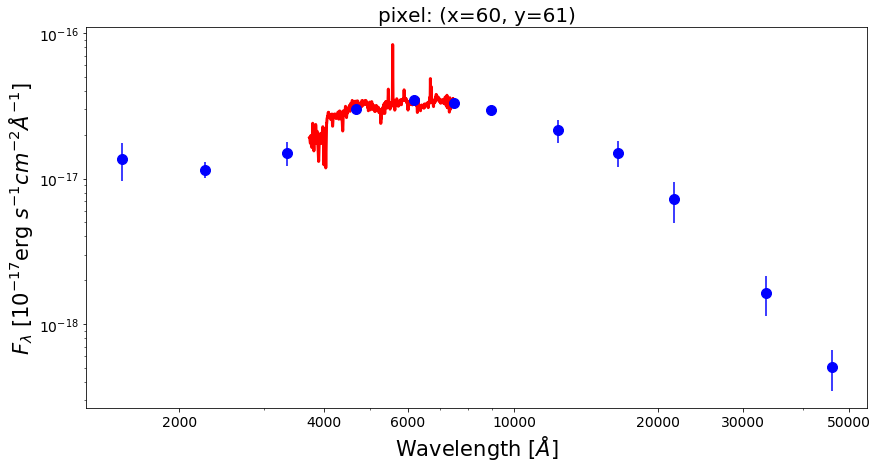

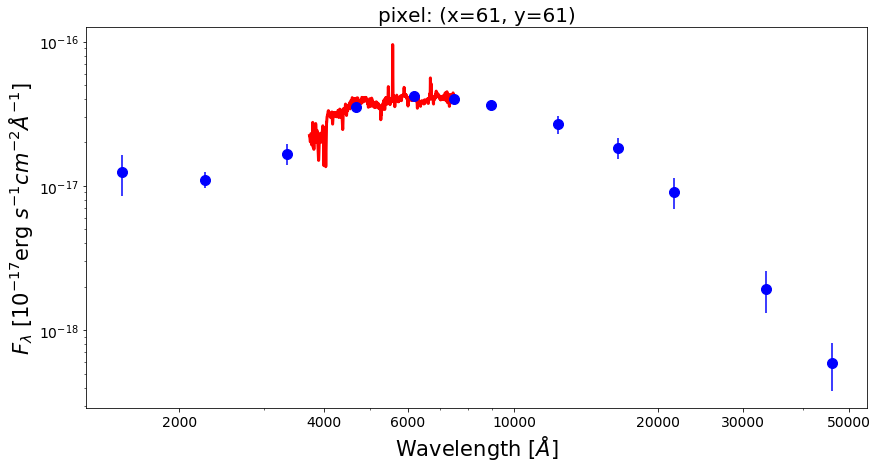

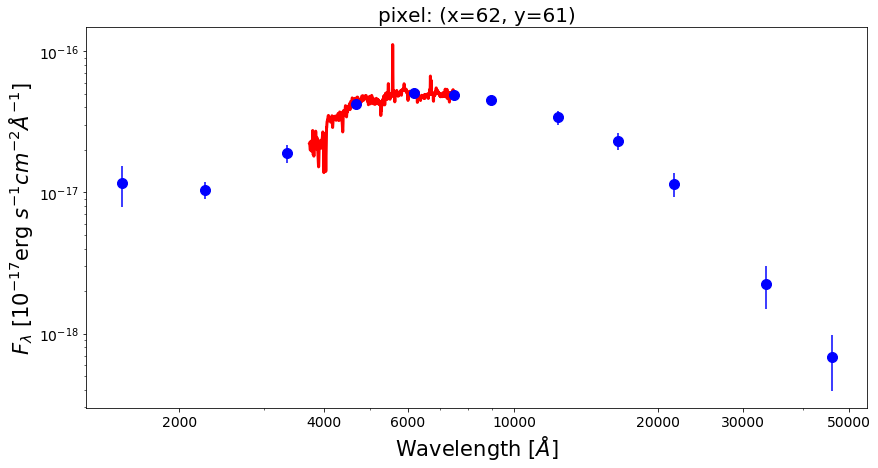

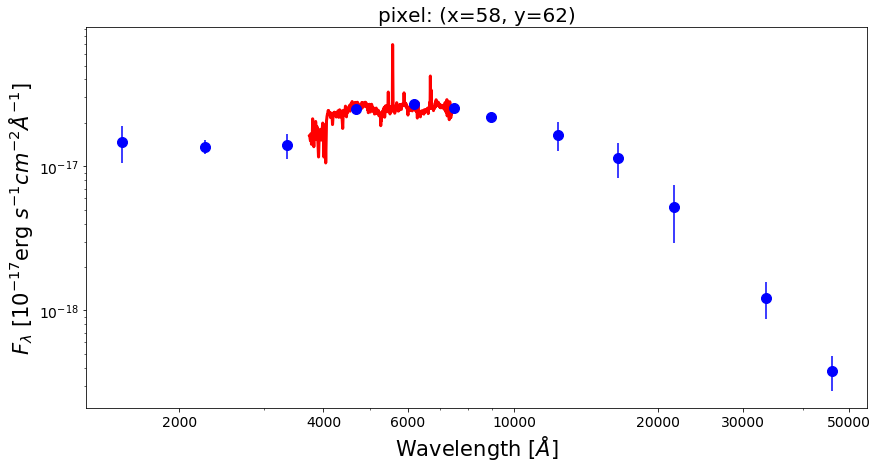

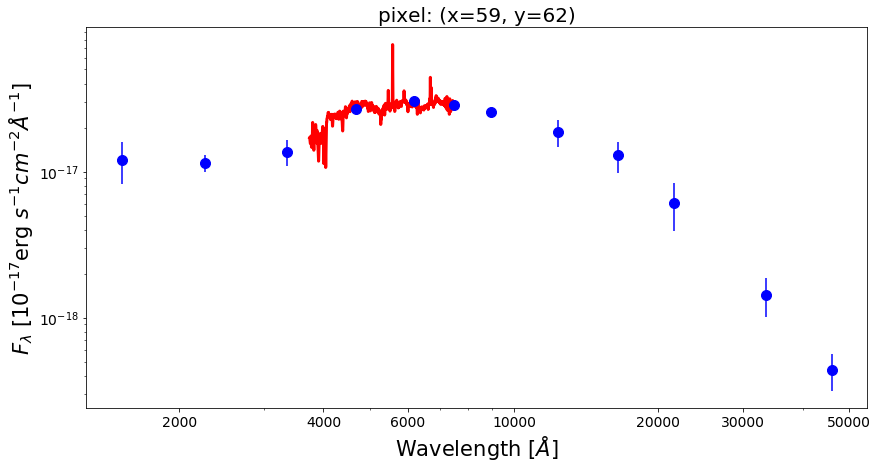

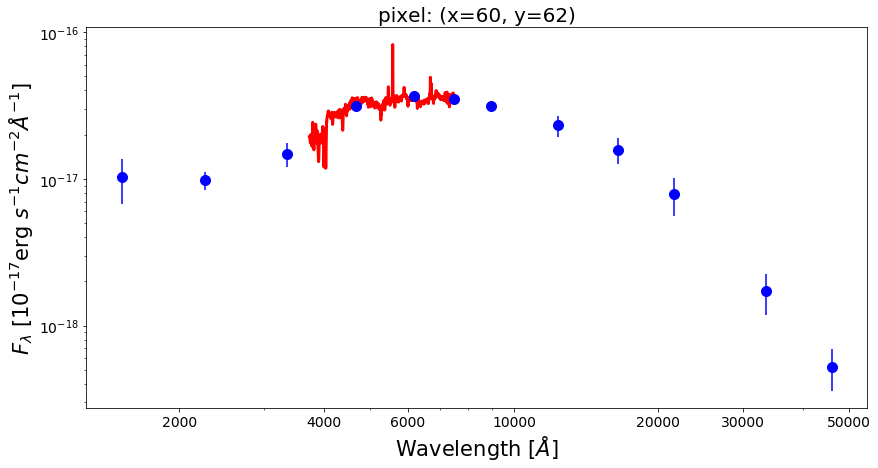

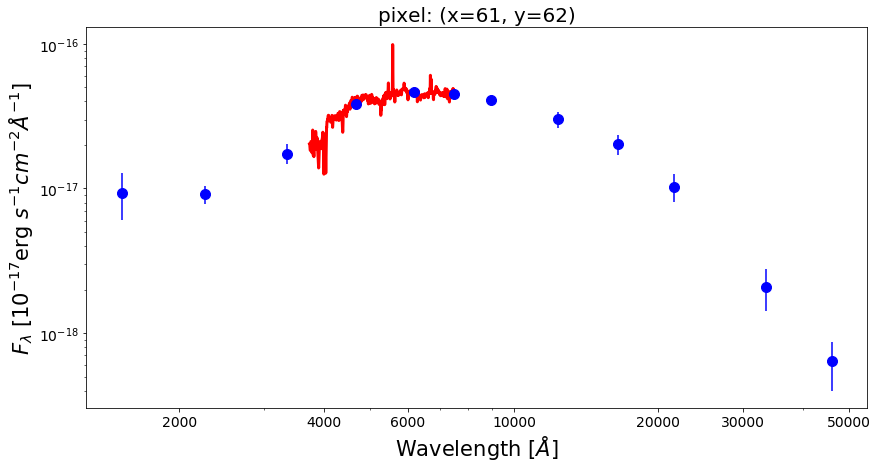

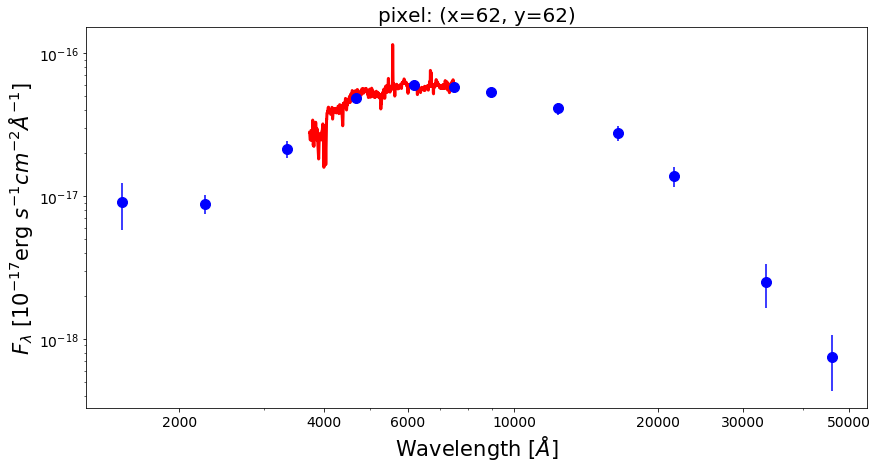

In [8]:
from matplotlib.ticker import ScalarFormatter

# Optional: cut the spectra around the edge to exclude those commonly uncertain fluxes
nwaves = len(wave)

for yy in range(58,63):
    for xx in range(58,63): 
        if spec_region[yy][xx]==1:
            fig1 = plt.figure(figsize=(14,7))
            f1 = plt.subplot()   
            plt.title("pixel: (x=%d, y=%d)" % (xx,yy), fontsize=20)
            f1.set_yscale('log')
            f1.set_xscale('log')
            plt.setp(f1.get_yticklabels(), fontsize=14)
            plt.setp(f1.get_xticklabels(), fontsize=14)
            plt.xlabel(r'Wavelength $[\AA]$', fontsize=21)
            plt.ylabel(r'$F_{\lambda}$ [$10^{-17}$erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
            xticks = [2000,4000,6000,10000,20000,30000,50000]
            plt.xticks(xticks)
            #plt.xlim(3000,10000)
            #plt.ylim(1.0e-19,8e-16)
            for axis in [f1.xaxis]:
                axis.set_major_formatter(ScalarFormatter())
            
            # Optional: cut the spectra around the edge to exclude 
            # those commonly uncertain fluxes
            plt.plot(wave[20:nwaves-20], pix_spec_SED[yy][xx][20:nwaves-20], lw=3.0, color='red')
            plt.errorbar(photo_wave, pix_photo_SED[yy][xx], yerr=pix_photo_SED_err[yy][xx], 
                         markersize=10,color='blue', fmt='o')
            
            #plt.plot(mod_wave, pix_mod_spec_SED[yy][xx], lw=1.0, color='black')